In [1]:
# default_exp datasets
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# Testing Diffusion Flow Embedder on Circle and Swiss Roll

In [2]:
from directed_graphs.datasets import directed_circle, directed_cylinder, directed_spiral, directed_swiss_roll
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np

In [3]:
'''
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from tqdm import trange
from directed_graphs.utils import diffusion_matrix_from_graph
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset

class DiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, X, flows, t = 4, sigma_graph = 0.5, sigma_embedding=0.5, embedding_dimension=2):
		"""Flow Embedding with diffusion

		Parameters
		----------
		X : torch tensor n_points x n_dim
			data matrix
		flows : torch tensor n_points x n_dim
			The flow at each point
		t : int
			Loss is computed with the diffusion operator powered to this number
		sigma in [0,1]
			Kernel bandwidth in the embedding
		"""
		# initialize parameters
		super(DiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.t = t
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		self.losses = []
		self.embedding_dimension = embedding_dimension
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph)
		self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# Flow field
		self.FlowArtist = nn.Sequential(nn.Linear(2, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 2))
		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, 100),
															nn.ReLU(),
															nn.Linear(100, 10),
															nn.ReLU(),
															nn.Linear(10, self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, 10),
															nn.ReLU(),
															nn.Linear(10, 100),
															nn.ReLU(),
															nn.Linear(100, self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.optim = torch.optim.Adam(self.parameters())
									

	def compute_embedding_P(self):
		A = affinity_matrix_from_pointset_to_pointset(self.embedded_points,self.embedded_points,flows = self.FlowArtist(self.embedded_points), sigma = self.sigma_embedding)
		# flow
		self.P_embedding = torch.diag(1/A.sum(axis=1)) @ A
		# power it
		self.P_embedding_t = torch.matrix_power(self.P_embedding,self.t)

	def loss(self):
		self.embedded_points = self.encoder(self.X)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# take KL divergence between it and actual P
		log_P_embedding_t = torch.log(self.P_embedding_t)
		diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		cost = diffusion_loss + reconstruction_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss])
		return cost

	def visualize_points(self, labels):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		minx = min(self.embedded_points[:,0].detach().cpu().numpy())-1
		maxx = max(self.embedded_points[:,0].detach().cpu().numpy())+1
		miny = min(self.embedded_points[:,1].detach().cpu().numpy())-1
		maxy = max(self.embedded_points[:,1].detach().cpu().numpy())+1
		x, y = np.meshgrid(np.linspace(minx,maxx,20),np.linspace(miny,maxy,20))
		x = torch.tensor(x,dtype=float).cpu()
		y = torch.tensor(y,dtype=float).cpu()
		xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().to('cuda')
		uv = self.FlowArtist(xy_t).detach()
		u = uv[:,:,0].cpu()
		v = uv[:,:,1].cpu()
		

		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		
		sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
		plt.quiver(x,y,u,v)
		plt.legend(labels = set(labels))
		# Display all open figures.
		plt.show()


	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		for step in trange(n_steps):
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points
'''

'\nimport torch\nfrom torch import nn\nimport torch.nn.functional as F\nimport torch_geometric\nfrom tqdm import trange\nfrom directed_graphs.utils import diffusion_matrix_from_graph\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset\n\nclass DiffusionFlowEmbedder(torch.nn.Module):\n\tdef __init__(self, X, flows, t = 4, sigma_graph = 0.5, sigma_embedding=0.5, embedding_dimension=2):\n\t\t"""Flow Embedding with diffusion\n\n\t\tParameters\n\t\t----------\n\t\tX : torch tensor n_points x n_dim\n\t\t\tdata matrix\n\t\tflows : torch tensor n_points x n_dim\n\t\t\tThe flow at each point\n\t\tt : int\n\t\t\tLoss is computed with the diffusion operator powered to this number\n\t\tsigma in [0,1]\n\t\t\tKernel bandwidth in the embedding\n\t\t"""\n\t\t# initialize parameters\n\t\tsuper(DiffusionFlowEmbedder, self).__init__()\n\t\tself.X = X\n\t\tself.ground_truth_flows = flows\n\t\tself.t = t\n\t\ts

In [4]:
if torch.__version__[:4] == "1.13":
	device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Flat Circle

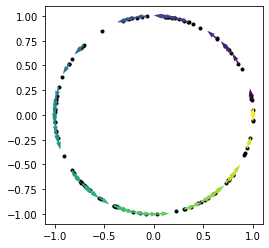

In [5]:
X, flow, labels = directed_circle(num_nodes=100, radius=1)
plot_directed_2d(X, flow, labels)

In [6]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [7]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:24<00:00, 81.23it/s]

Exiting training with loss  tensor(425.1522, device='cuda:0', grad_fn=<AddBackward0>)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


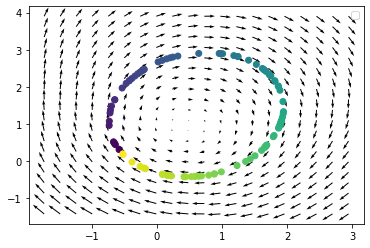

In [8]:
dfe.visualize_points(labels)

## Tilted Circle

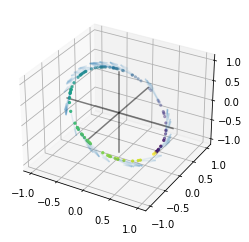

In [9]:
X, flow, labels = directed_circle(num_nodes=100, radius=1, ytilt=np.pi/4)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [10]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [11]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:22<00:00, 88.29it/s]

Exiting training with loss  tensor(425.1523, device='cuda:0', grad_fn=<AddBackward0>)


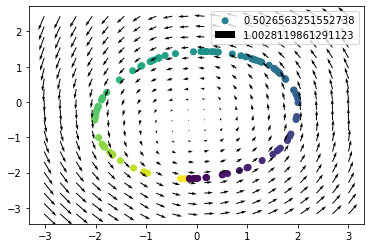

In [12]:
dfe.visualize_points(labels)

## Cylinder

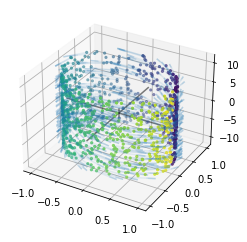

In [13]:
X, flow, labels = directed_cylinder(num_nodes=1000, radius=1, height=20, xtilt=np.pi/4, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [14]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [15]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:23<00:00, 85.76it/s]

Exiting training with loss  tensor(6685.0879, device='cuda:0', grad_fn=<AddBackward0>)


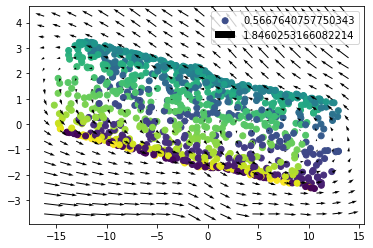

In [16]:
dfe.visualize_points(labels)

## Flat Spiral

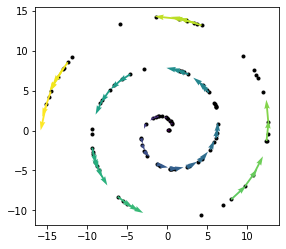

In [17]:
X, flow, labels = directed_spiral(num_nodes=100, num_spirals=2.5, radius=1)
plot_directed_2d(X, flow, labels)

In [18]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [19]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:22<00:00, 88.26it/s]

Exiting training with loss  tensor(470.7578, device='cuda:0', grad_fn=<AddBackward0>)


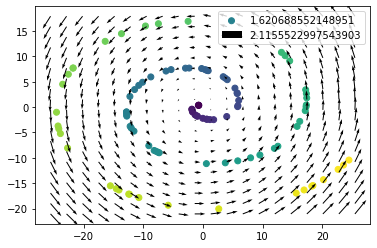

In [20]:
dfe.visualize_points(labels)

## Tilted Spiral

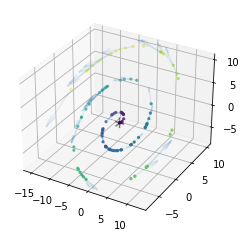

In [21]:
X, flow, labels = directed_spiral(num_nodes=100, num_spirals=2.5, radius=1, xtilt=np.pi/4)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [22]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [23]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:22<00:00, 89.10it/s]

Exiting training with loss  tensor(361.4885, device='cuda:0', grad_fn=<AddBackward0>)


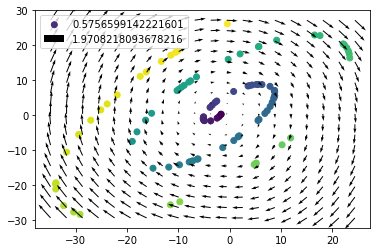

In [24]:
dfe.visualize_points(labels)

## Swiss Roll

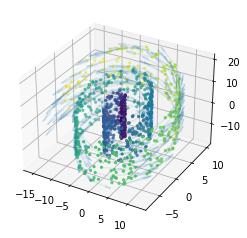

In [25]:
X, flow, labels = directed_swiss_roll(num_nodes=1000, num_spirals=2.5, radius=1, height=20, xtilt=np.pi/4, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [26]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [27]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:23<00:00, 85.44it/s]

Exiting training with loss  tensor(243673.6562, device='cuda:0', grad_fn=<AddBackward0>)


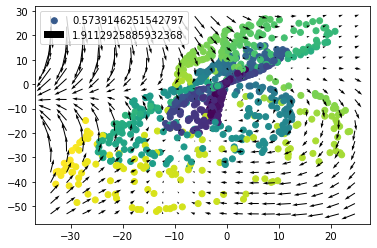

In [28]:
dfe.visualize_points(labels)

Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.61 seconds.
Calculated PHATE in 2.87 seconds.


/tmp/ipykernel_222039/2472049010.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(phate_X, c=labels)


<AxesSubplot:>

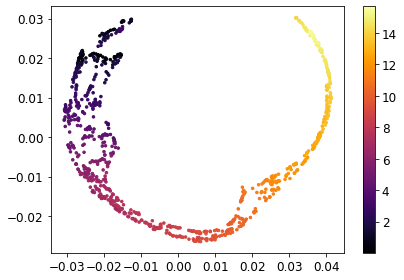

In [32]:
import phate
phate_operator = phate.PHATE(n_components = 2, knn=5, decay=20, t=150)
phate_X = phate_operator.fit_transform(X.cpu())
phate.plot.scatter2d(phate_X, c=labels)